### Importing Libraries

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import math
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pre-processing - Training and Testing sets

In [5]:

# Paths
base_dir = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

# Hyperparams
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4
NUM_CLASSES = 4  # (vasc, nv, df, bkl)

#############################
# DATA GENERATORS
#############################
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3}


## Building the ResNet50 Model, 50 Epochs No Early Stopping

### Model Structure

1. **Base Model: ResNet50**
   - Pretrained on **ImageNet**
   - **include_top=False** (fully-connected layers removed)
   - **Input Shape:** (224, 224, 3)
   - **Layer Trainability:** All base ResNet50 layers are frozen
   - **Residual Blocks:**
     - Standard ResNet50 architecture with 5 main stages of convolutional + identity blocks
     - Since `include_top=False`, the original Dense layers are excluded

2. **Custom Classification Head**
   - **Global Average Pooling Layer**  
     - Converts final convolutional feature maps into a single 1D vector
   - **Dense Layer (1024 neurons)**  
     - **Activation:** ReLU
   - **Dropout (0.5)**  
     - Reduces overfitting by randomly dropping 50% of neurons
   - **Output Layer (4 neurons)**  
     - **Activation:** Softmax
     - Produces probabilities for the 4 target classes

---

### Training Details

1. **Phase 1 (Feature Extraction)**
   - **Freeze:** All ResNet50 layers
   - **Train:** Only the newly added classification layers

2. **Hyperparameters**
   - **Optimizer:** Adam
     - **Learning Rate:** 1e-4
   - **Loss Function:** Categorical Crossentropy
   - **Metric:** Accuracy
   - **Batch Size:** 32
   - **Epochs:** 20

3. **Data Generators**
   - **ImageDataGenerator:** Uses `preprocess_input` from ResNet50
   - **Validation Split:** 20% (i.e., 0.2)
   - **Target Size:** (224, 224)
   - **Shuffle:** True for training, False for validation

4. **Callbacks**
   - **ModelCheckpoint:** Saves the best model (monitors validation accuracy)



In [6]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


#TRAINING THE MODEL

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

callbacks_list = [checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6091 - loss: 1.0548 
Epoch 1: val_accuracy improved from -inf to 0.77000, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 2789s 28s/step - accuracy: 0.6106 - loss: 1.0509 - val_accuracy: 0.7700 - val_loss: 0.7047
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8975 - loss: 0.2867
Epoch 2: val_accuracy improved from 0.77000 to 0.82375, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.8974 - loss: 0.2867 - val_accuracy: 0.8238 - val_loss: 0.6065
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9270 - loss: 0.2093
Epoch 3: val_accuracy improved from 0.82375 to 0.85750, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9270 - loss: 0.2093 - val_accuracy: 0.8575 - val_loss: 0.4941
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9322 - loss: 0.1763
Epoch 4: val_accuracy improved from 0.85750 to 0.86250, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.9323 - loss: 0.1762 - val_accuracy: 0.8625 - val_loss: 0.5010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9596 - loss: 0.1249
Epoch 5: val_accuracy improved from 0.86250 to 0.87375, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.9596 - loss: 0.1250 - val_accuracy: 0.8737 - val_loss: 0.5187
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9608 - loss: 0.1176
Epoch 6: val_accuracy did not improve from 0.87375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9609 - loss: 0.1176 - val_accuracy: 0.8587 - val_loss: 0.5862
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9701 - loss: 0.0941
Epoch 7: val_accuracy did not improve from 0.87375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - accuracy: 0.9701 - loss: 0.0940 - val_accuracy: 0.8550 - val_loss: 0.6016
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9780 - loss: 0.0669
Epoch 8: val_accuracy did not improve from 0.87375
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9780 - loss: 0.0670 - val_accuracy: 0.8612 - val_loss: 0.5422
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9784 - loss: 0.0733
Epoch 9: val_ac

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.9860 - loss: 0.0537 - val_accuracy: 0.8775 - val_loss: 0.6023
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9848 - loss: 0.0501
Epoch 12: val_accuracy did not improve from 0.87750
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9848 - loss: 0.0502 - val_accuracy: 0.8575 - val_loss: 0.5392
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9926 - loss: 0.0340
Epoch 13: val_accuracy did not improve from 0.87750
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9925 - loss: 0.0341 - val_accuracy: 0.8575 - val_loss: 0.6345
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9923 - loss: 0.0333
Epoch 14: val_accuracy did not improve from 0.87750
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - accuracy: 0.9923 - loss: 0.0333 - val_accuracy: 0.8750 - val_loss: 0.5714
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9947 - loss: 0.0308
Epoch 15

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9981 - loss: 0.0203 - val_accuracy: 0.8800 - val_loss: 0.6170
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9981 - loss: 0.0170
Epoch 21: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9981 - loss: 0.0170 - val_accuracy: 0.8712 - val_loss: 0.5961
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9974 - loss: 0.0161
Epoch 22: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9974 - loss: 0.0160 - val_accuracy: 0.8788 - val_loss: 0.6107
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9974 - loss: 0.0167
Epoch 23: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.9974 - loss: 0.0167 - val_accuracy: 0.8712 - val_loss: 0.5689
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9978 - loss: 0.0164
Epoch 24

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.9995 - loss: 0.0110 - val_accuracy: 0.8850 - val_loss: 0.6140
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9967 - loss: 0.0132
Epoch 27: val_accuracy did not improve from 0.88500
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9967 - loss: 0.0132 - val_accuracy: 0.8788 - val_loss: 0.5955
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9994 - loss: 0.0097
Epoch 28: val_accuracy did not improve from 0.88500
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9994 - loss: 0.0097 - val_accuracy: 0.8825 - val_loss: 0.5997
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9992 - loss: 0.0102
Epoch 29: val_accuracy improved from 0.88500 to 0.89000, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.9992 - loss: 0.0102 - val_accuracy: 0.8900 - val_loss: 0.6213
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9992 - loss: 0.0067
Epoch 30: val_accuracy did not improve from 0.89000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.8788 - val_loss: 0.5231
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9997 - loss: 0.0090
Epoch 31: val_accuracy did not improve from 0.89000
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9997 - loss: 0.0090 - val_accuracy: 0.8850 - val_loss: 0.5575
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9988 - loss: 0.0072
Epoch 32: val_accuracy did not improve from 0.89000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9989 - loss: 0.0072 - val_accuracy: 0.8825 - val_loss: 0.6035
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9998 - loss: 0.0070
Epoch 33

### Evaluation Metrics - Performance of the Model

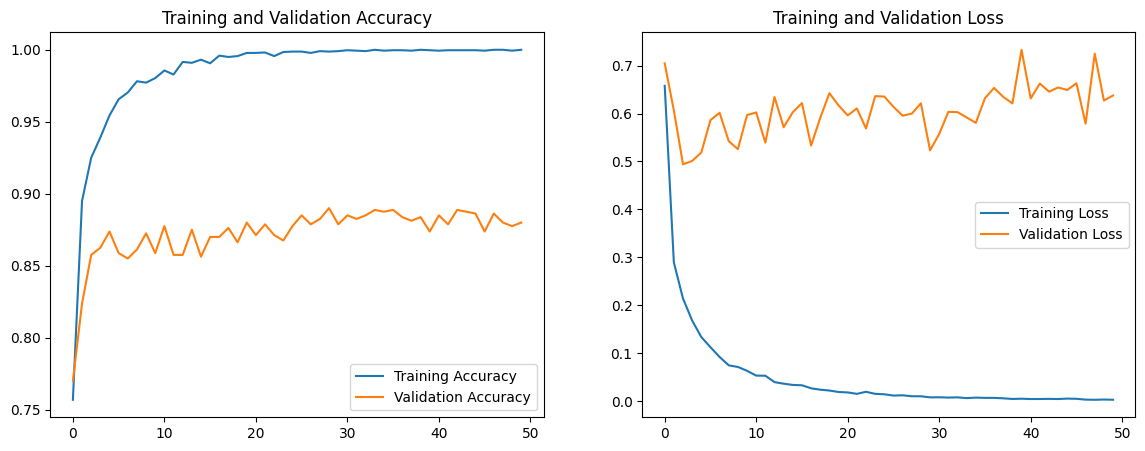

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step


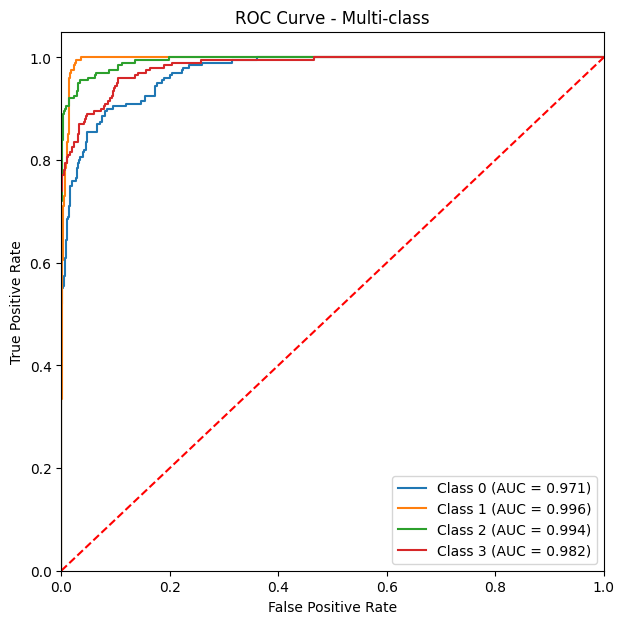

In [7]:
#PLOT ACCURACY & LOSS

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# EVALUATE AUC-ROC

valid_generator.reset()
y_pred_proba = model.predict(valid_generator)
y_true = valid_generator.classes
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

plt.figure(figsize=(7,7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.3f})'.format(i, roc_auc))

plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()


### Confusion Matrix and Classifcation Report

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step
Confusion Matrix:
[[132   0  18  50]
 [  0 198   1   1]
 [  6   2 191   1]
 [  0  13   4 183]]


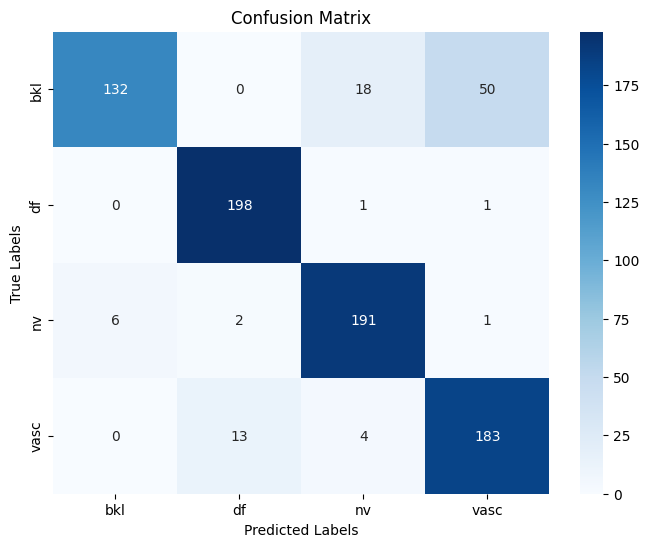

Classification Report:
              precision    recall  f1-score   support

         bkl       0.96      0.66      0.78       200
          df       0.93      0.99      0.96       200
          nv       0.89      0.95      0.92       200
        vasc       0.78      0.92      0.84       200

    accuracy                           0.88       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



In [8]:
# Ensure the generator is reset to predict the entire validation set
valid_generator.reset()

# Calculate the number of steps (ceil to include all samples)
steps = math.ceil(valid_generator.samples / valid_generator.batch_size)

# Predict the probabilities for the validation set and then the class indices
y_pred = model.predict(valid_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the generator
y_true = valid_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Get class names in the correct order from the generator mapping
target_names = [None] * len(train_generator.class_indices)
for key, value in train_generator.class_indices.items():
    target_names[value] = key

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate and print the classification report
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(report)


### Validation Accuracy for the Best Model

In [9]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.h5')

# Evaluate the model on the validation set
val_loss, val_acc = best_model.evaluate(valid_generator, steps=valid_generator.samples // BATCH_SIZE)
print(f"Best Model Validation Accuracy: {val_acc:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8377 - loss: 0.9905
Best Model Validation Accuracy: 0.8900
